# MSA

The MSA module of MIToS has utilities for working with Multiple Sequence Alignments of protein Sequences (MSA).

## Features

- [**Read**](#Reading-MSA-files) and [**write**](#Writing-MSA-files) MSAs in `Stockholm`, `FASTA` or `Raw` format
- Handle [**MSA annotations**](#MSA-Annotations)
- [**Edit the MSA**](#Editing-your-MSA), e.g. delete columns or sequences, change sequence order, shuffling...
- [**Keep track of positions**](#Column-and-sequence-mappings) and annotations after modifications on the MSA
- Describe a MSA, e.g. mean percent identity, sequence coverage, gap percentage...
- [**Sequence clustering**](#Sequence-clustering) with Hobohm I 

In [1]:
using MIToS.MSA

## MSA IO

### Reading MSA files

The main function for reading files in MIToS is `read` and it is defined in the `Utils` module. This function takes a filename/path and lot of arguments, opens the file and uses the arguments to call the `parse` function. `read` decides how to open the file, using the prefixes and suffixes of the file name, while `parse` does the actual parsing of the file. You can `read` **gzipped files** if they have the `.gz` extension and also **files of the web**.  
The second argument of `read` and `parse` is the file `Format`. The supported MSA formats at the moment are `Stockholm`, `FASTA` and `Raw`.  
For example, reading in Julia the full Stockholm MSA of the family PF07388 using the Pfam RESTful interface will be:

In [2]:
read("http://pfam.xfam.org/family/PF07388/alignment/full", Stockholm)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4168  100  4168    0     0   1675      0  0:00:02  0:00:02 --:--:--  1675


4x458 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 -  -  -  -  -  -  -  -  -  -  -  -  -  …  -  -  -  -  -  -  -  -  -  -  -  -
 M  L  K  K  I  K  K  A  L  F  Q  P  K     -  -  -  -  -  -  -  -  -  -  -  -
 -  -  K  K  L  S  G  L  M  Q  D  I  K     D  F  Q  K  Y  R  I  K  Y  L  Q  L
 -  -  -  -  -  -  -  -  -  -  -  -  -     -  -  -  -  -  -  -  -  -  -  -  -

The third (and optional) argument of `read` and `parse` is the output MSA type:  
  
<p>
    <dl>
    
        <dt><code>Matrix{Residue}</code></dt>
        <dd>It is the default output format for a <code>Raw</code> file.</dd>
        
        <dt><code>MultipleSequenceAlignment</code></dt>
        <dd>It contains the sequence names/identifiers.</dd>
        
        <dt><code>AnnotatedMultipleSequenceAlignment</code></dt>
        <dd>The richest MSA format of MIToS and the default for <code>FASTA</code> and <code>Stockholm</code> files. It includes sequences names and MSA annotations.</dd>
       
    </dl>
</p>


In [3]:
read("http://pfam.xfam.org/family/PF07388/alignment/full", Stockholm, Matrix{Residue})

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4168  100  4168    0     0  14322      0 --:--:-- --:--:-- --:--:-- 14372


4x458 Array{MIToS.MSA.Residue,2}:
 -  -  -  -  -  -  -  -  -  -  -  -  -  …  -  -  -  -  -  -  -  -  -  -  -  -
 M  L  K  K  I  K  K  A  L  F  Q  P  K     -  -  -  -  -  -  -  -  -  -  -  -
 -  -  K  K  L  S  G  L  M  Q  D  I  K     D  F  Q  K  Y  R  I  K  Y  L  Q  L
 -  -  -  -  -  -  -  -  -  -  -  -  -     -  -  -  -  -  -  -  -  -  -  -  -

Given that `read` call `parse`, you should look into the documentation of the last one to know the available keyword arguments. The optional keyword arguments using in MSA IO are:

<p>
<dl class="dl-horizontal">

<dt><code>generatemapping</code></dt>
<dd>
If <code>checkalphabet</code> is <code>true</code> (default to <code>false</code>), sequence and columns mapping are generated and saved in the MSA annotations. <span class="text-warning">The default is <code>false</code> to not overwrite mappings by mistake when you read an annotated MSA file saved with MIToS.</span>
</dd>

<dt><code>useidcoordinates</code></dt>
<dd>
If <code>useidcoordinates</code> is <code>true</code> (default to <code>false</code>), MIToS uses the coordinates in the sequence names of the form <i>seqname/start-end</i> to generate sequence mappings. This is safe and useful with fresh downloaded Pfam MSAs. <span class="text-warning">Please be careful if you are reading a MSA saved with MIToS. MIToS deletes unaligned insert columns, therefore the sequences would be disrupted if there were insert columns.</span>
</dd>

<dt><code>checkalphabet</code></dt>
<dd>
The <code>parse</code> function converts each character in sequence strings to a MIToS <code>Residue</code>. Lowercase characters, dots and degenerated or non standard residues are converted to gaps. If <code>checkalphabet</code> is <code>true</code> (<code>false</code> by default), <code>read</code> deletes all the sequences with non-standard residues. The 20 natural residues are A, R, N, D, C, Q, E, G, H, I, L, K, M, F, P, S, T, W, Y and V.
</dd>

<dt><code>deletefullgaps</code></dt>
<dd>
Given that lowercase characters and dots are converted to gaps, unaligned insert columns in a MSA derived from a HMM profile are converted into full gap columns. <code>deletefullgaps</code> is <code>true</code> by default, deleting full gaps columns and therefore insert columns.
</dd>

</dl>
</p>

<div class="panel panel-warning">
<div class="panel-heading">
		<strong>If you are deriving scores from gaps...</strong>
	</div>
	<div class="panel-body">
		If you are using MIToS to derive information scores from gaps, you will want to set <code>checkalphabet</code> to <code>true</code>. This prevents counting non standard residues as gaps.
	</div>
</div>

When `read` returns an `AnnotatedMultipleSequenceAlignment`, it uses the MSA `Annotations` to inform about performed modifications on the MSA. To access this notes, use `printmodifications`:

In [4]:
msa = read("http://pfam.xfam.org/family/PF01565/alignment/full", Stockholm, checkalphabet=true)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.0M  100 10.0M    0     0  69485      0  0:02:31  0:02:31 --:--:-- 23195


12364x139 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 P  S  L  I  A  R  C  K  S  A  D  D  V  …  V  V  T  A  D  G  R  Q  L  -  -  -
 P  L  V  I  V  T  A  L  N  V  A  H  I     L  I  D  V  K  G  R  I  L  -  -  -
 -  -  -  -  -  -  -  -  -  -  -  -  -     L  V  L  A  D  G  S  L  V  R  C  S
 P  S  Y  V  V  K  A  T  N  V  A  Q  I     V  V  T  P  D  G  R  F  V  T  A  -
 P  R  A  A  V  R  C  A  T  A  E  A  V     L  F  E  G  T  G  V  V  E  W  V  -
 P  D  V  V  V  L  P  K  N  V  G  Q  V  …  V  V  L  P  N  G  D  V  L  -  -  -
 -  A  Y  Y  I  T  P  H  N  E  T  A  L     -  V  -  -  -  -  -  -  -  -  -  -
 P  L  C  I  V  T  P  R  N  A  S  H  V     M  V  D  A  N  G  N  L  L  -  -  -
 P  S  I  V  I  A  P  G  T  E  N  D  V     I  V  L  A  N  G  D  F  -  -  -  -
 P  A  A  V  L  R  P  R  S  A  Q  D  I     V  V  T  G  T  G  E  L  V  R  C  S
 -  -  -  -  -  -  -  -  -  -  -  -  -  …  V  C  D  G  D  -  -  -  -  -  -  -
 P  P  F  V  V  N  A  T  E  P  G  H  V     V  V  T  P  T  G  E  V  V  A  -  -
 -  -  L

In [5]:
printmodifications(msa)

-------------------


<a href="#"><i class="fa fa-arrow-up"></i></a>

### Writing MSA files

Julia REPL shows MSAs as Matrices. If you want to print them in a determined MSA format, you should use the `print` function with an MSA object as first argument and the `Format` `FASTA`,  `Stockholm` or `Raw` as second argument.

In [6]:
msa = read("http://pfam.xfam.org/family/PF16996/alignment/full", Stockholm) # reads a Stockholm MSA file

print(msa, FASTA) # prints msa in FASTA format

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

2016-03-07T18:06:12

deletenotalphabetsequences!  :  Deletes 21 sequences with ambiguous or not standard residues (Alphabet: ARNDCQEGHILKMFPSTWYV-. )
filtersequences! : 21 sequences have been deleted.
deletefullgaps!  :  Deletes 621 columns full of gaps (inserts generate full gap columns on MIToS because lowercase and dots are not allowed)
filtercolumns! : 621 columns have been deleted.


100  1118  100  1118    0     0   3624      0 --:--:-- --:--:-- --:--:--  3618


>T0TY77_9STRE/5-60
KKDLFYKEVEGRMESLKRRPAEKEKTTRSEKINVTFNVIIGLVILLGVIFTLF-RV


To save a MSA object to a file, use the `write` function. This function takes a filename as a first argument. If the filename ends with `.gz`, the output will be a compressed (gzipped) file. The next to arguments of `write` are passed to `print`, so `write` behaves in the same way.   

In [7]:
write("msa.gz", msa, FASTA) # writes msa in FASTA format in a gzipped file

In [8]:
;zcat msa.gz

>A8AWV6_STRGC/3-58
KKDLFYKDIEGRLDELKHGRPKKEKASLGEKFNKAFVIALGLMILIGLIFTLIGV-


<div class="panel panel-info">
    <div class="panel-heading">
        <strong>Julia shell mode</strong>
    </div>
    <div class="panel-body">
        <p>A semicolon (<code>;</code>) next to Julia prompt, at the beginning of the line, enters the shell mode. This mode uses the system shell to execute system commands.</p>
    </div>
</div>

<a href="#"><i class="fa fa-arrow-up"></i></a>

### MSA Annotations

MSA annotations are based on the Stockholm format mark-ups. There are four types of annotations store as dictionaries. All the annotations has a feature name as part of the key, which should be a single “word” (without spaces) and less than 50 characters.

<p>
	<dl class="dl-horizontal">

		<dt>File annotations</dt>
		<dd>
		They are used as per file or per MSA annotations. They have feature names as keys and the values are strings (free text). Lines starting with <code>#=GF</code> in Stockholm files.
		</dd>

		<dt>Column annotations</dt>
		<dd>
		They have feature names as keys and strings with exactly 1 char per column as values. They are indicated with <code>#=GC</code> in Stockholm format.
</dd>

		<dt>Sequence annotations</dt>
		<dd>
		The keys are tuples with the sequence name and the feature name. The values are free text (strings). Lines beginning with <code>#=GS</code> in Stockholm format.
		</dd>

		<dt>Residue annotations</dt>
		<dd>
		The keys are tuples with the sequence name and the feature name. The values are strings with exactly 1 char per column/residues. <code>#=GS</code> lines in Stockholm format.
		</dd>

	</dl>
</p>

Julia REPL shows the `Annotations` type as they are represented in the [Stockholm format<span class="fa fa-external-link" aria-hidden="true"></span>](https://en.wikipedia.org/wiki/Stockholm_format). You can get the `Annotations` inside an annotated MSA or sequence using the `annotations` function.


In [9]:
annotations(msa)

#=GF ID   Asp4
#=GF AC   PF16996.2
#=GF DE   Accessory secretory protein Sec Asp4
#=GF AU   Coggill P
#=GF SE   Pfam-B_7603 (release 27.0)
#=GF GA   25.70 25.70;
#=GF TC   26.00 113.50;
#=GF NC   22.10 19.80;
#=GF BM   hmmbuild HMM.ann SEED.ann
#=GF SM   hmmsearch -Z 11927849 -E 1000 --cpu 4 HMM pfamseq
#=GF TP   Family
#=GF RN   [1]
#=GF RM   23000954
#=GF RT   Emerging themes in SecA2-mediated protein export.
#=GF RA   Feltcher ME, Braunstein M;
#=GF RL   Nat Rev Microbiol. 2012;10:779-789.
#=GF CC   Asp4 and Asp5 are putative accessory components of the SecY2
#=GF CC   channel of the SecA2-SecY2 mediated export system, but they are
#=GF CC   not present in all SecA2-SecY2 systems. This family of Asp4 is
#=GF CC   found in Firmicutes [1].
#=GF SQ   2
#=GF MIToS_2016-03-07T18:06:12   deletefullgaps!  :  Deletes 1 columns full of gaps (inserts generate full gap columns on MIToS because lowercase and dots are not allowed)
#=GF MIToS_2016-03-07T18:06:12   filtercolumns! : 1 columns have 

Particular annotations can be accessed using the functions `getannot...`. This functions take the MSA/sequence as first argument and the feature name of the desired annotation. In the case of `getannotsequence` and `getannotresidue`, the second argument should be the sequence name.

In [10]:
getannotsequence(msa, "A8AWV6_STRGC/3-58", "AC")

>T0TY77_9STRE/5-60
KKDLFYKEVEGRMESLKRRPAEKEKTTRSEKINVTFNVIIGLVILLGVIFTLF-RV
>A8AWV6_STRGC/3-58
KKDLFYKDIEGRLDELKHGRPKKEKASLGEKFNKAFVIALGLMILIGLIFTLIGV-


"A8AWV6.1"

If you want to add new annotations, you should use  the `setannot…!` functions. This functions has the same arguments that `getannot...` functions but with a last extra argument to indicate the new annotation.

In [11]:
setannotsequence!(msa, "A8AWV6_STRGC/3-58", "New_Feature_Name", "New_Annotation")

"New_Annotation"

A `getannot...` function without the keys (last arguments), returns the particular annotation dictionary.  
As you can see, the new sequence annotation is now part of our MSA annotations.  

In [12]:
getannotsequence(msa)

Dict{Tuple{ASCIIString,ASCIIString},ASCIIString} with 3 entries:
  ("A8AWV6_STRGC/3-58","N… => "New_Annotation"
  ("T0TY77_9STRE/5-60","A… => "T0TY77.1"
  ("A8AWV6_STRGC/3-58","A… => "A8AWV6.1"

<a href="#"><i class="fa fa-arrow-up"></i></a>

### Editing your MSA

MIToS offers functions to edit your MSA. Given that this functions modify the msa, their names end with a bang `!`, following the Julia convention. Some of this functions has an `annotate` keyword argument (in general it is `true` by default) to indicate if the modification should be recorded in the MSA/sequence annotations.  

One common task is to delete sequences or columns of the MSA. This could be done using the functions `filtersequences!` and `filtercolumns!`. This functions take the MSA or sequence (if it’s possible) as first argument and a `BitVector` mask as second argument, and delete all the sequences or columns where the mask is `false`. This functions are also defined for `Annotations`, this allows to automatically update (modificate) the annotations (and therefore sequence and column mappings) together with the MSA.  

This two deleting operations are the base of the following mutating functions:  

<p>
	<dl class="dl-horizontal">
		<dt><code>setreference!</code></dt>
		<dd>Sets one of the sequences as the first sequence of the MSA (query or reference sequence)</dd>

		<dt><code>adjustreference!</code></dt>
		<dd>Deletes columns with gaps in the first sequence of the MSA (reference)</dd>

		<dt><code>gapstrip!</code></dt>
		<dd>This function first calls <code>adjustreference!</code>, then deletes sequences with low coverage and finally columns with lot of gaps.</dd>

	</dl>
</p>

Also, there are available a number of `shuffle_…!` functions useful to generate random alignments. The `Information` module of `MIToS` uses them to calculate the Z score of MI values.

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Deleting sequences

For example, if you want to keep only the proteins from *Actinobacteria* you can delete all the sequences that don’t have `_9ACTN` in their UniProt entry names:

In [13]:
msa = read("http://pfam.xfam.org/family/PF07388/alignment/full", Stockholm)

names(msa) # the function names returns the sequence names in the MSA

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4168  100  4168    0     0  13898      0 --:--:-- --:--:-- --:--:-- 13939


4-element IndexedArrays.IndexedArray{ASCIIString}:
 "M5A3D2_9ACTN/208-402"
 "Q4W584_NEIMB/1-222"  
 "C5ZW53_9HELI/1-498"  
 "M5A3D2_9ACTN/2-157"  

In [14]:
mask = map(x -> ismatch(r"_9ACTN", x), names(msa)) # an element of mask is true if "_9ACTN" is in the name

4-element Array{Bool,1}:
  true
 false
 false
  true

In [15]:
filtersequences!(msa, mask) # deletes all the sequences where mask is false

names(msa)

2-element IndexedArrays.IndexedArray{ASCIIString}:
 "M5A3D2_9ACTN/208-402"
 "M5A3D2_9ACTN/2-157"  

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Exporting a MSA for freecontact (part I)

The most simple input for the command line tool [freecontact<span class="fa fa-external-link" aria-hidden="true"></span>](#https://rostlab.org/owiki/index.php/FreeContact) (if you don’t want to set `--mincontsep`) is a `Raw` MSA file with a reference sequence without insertions or gaps. This is easy to get with MIToS using `read` (deletes the insert columns), `setreference!` (to choose a reference), `adjustreference!` (to delete columns with gaps in the reference) and `write` (to save it in `Raw` format) functions.  

In [16]:
msa = read("http://pfam.xfam.org/family/PF02476/alignment/full", Stockholm)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1610  100  1610    0     0   5399      0 --:--:-- --:--:-- --:--:--  5402


3x126 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 M  L  E  S  E  V  S  G  N  A  P  H  S  …  Q  M  T  P  G  R  L  F  C  C  -  -
 L  L  H  Q  E  R  P  G  P  R  L  Y  H     H  P  -  -  T  Q  R  P  C  F  T  C
 -  L  H  R  D  Q  P  S  P  R  L  Y  H     H  P  -  -  V  R  R  P  C  C  A  C

In [17]:
maxcoverage, indice = findmax(coverage(msa)) # chooses the sequence with more coverage of the MSA

(0.9841269841269841,2)

In [18]:
setreference!(msa, indice)

3x126 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 L  L  H  Q  E  R  P  G  P  R  L  Y  H  …  H  P  -  -  T  Q  R  P  C  F  T  C
 M  L  E  S  E  V  S  G  N  A  P  H  S     Q  M  T  P  G  R  L  F  C  C  -  -
 -  L  H  R  D  Q  P  S  P  R  L  Y  H     H  P  -  -  V  R  R  P  C  C  A  C

In [19]:
adjustreference!(msa)

3x124 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 L  L  H  Q  E  R  P  G  P  R  L  Y  H  …  A  T  H  P  T  Q  R  P  C  F  T  C
 M  L  E  S  E  V  S  G  N  A  P  H  S     P  P  Q  M  G  R  L  F  C  C  -  -
 -  L  H  R  D  Q  P  S  P  R  L  Y  H     T  S  H  P  V  R  R  P  C  C  A  C

In [20]:
write("tofreecontact.msa", msa, Raw)

In [21]:
;cat tofreecontact.msa

LLHQERPGPRLYHLWVVGAADLCVPFFEYAQKTRRFIATKTNDAWVGEPWPLPDRFLPERTVSWTPFPAAPNHPLENLLSRYEYQYGVVVPRWLRSLVAPHKPRPASSRPHPATHPTQRPCFTC
MLESEVSGNAPHSLWIVGAADICRIALECIPLPKRLLAIKVSGTWSGMPWAIPDNIQTLLTSTWEPKFDTPEDRAHFCDSDMVCVYKILGS----------PPNPLKPPEIEPPQMGRLFCC--
-LHRDQPSPRLYHLWVVGAADLCVPFLEYAQKIRRFIAIKTPDAWVGEPWAVPTRFLPEWTVAWTPFPAAPNHPLETLLSRYEYQYGVVLPRWLRSLIALHKPHPATPGPLTTSHPVRRPCCAC


<a href="#"><i class="fa fa-arrow-up"></i></a>

## Column and sequence mappings

Inserts in a Stockholm MSA allow to access the full fragment of the aligned sequences. Using this, combined with the sequence names with coordinates used in Pfam, you can know what is the UniProt residue number of each residue in the MSA.   

```julia
"PROT_SPECI/3-15 .....insertALIGNED"
#                     3456789111111
#                            012345
```

MIToS `read` and `parse` functions deletes the insert columns, but they  do the mapping of each residue to its residue number before deleting insert columns if `generatemapping` is `true`. If you don’t set `useidcoordinates` to `true`, the residue first `i` residue will be 1 instead of 3.  

In [22]:
msa = parse("PROT_SPECI/3-15 .....insertALIGNED", Stockholm, generatemapping=true, useidcoordinates=true)

1x7 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 A  L  I  G  N  E  D

MIToS also keeps the column number of the input MSA and its total number of columns. All this data is stored in the MSA annotations using the `SeqMap`, `ColMap` and `NCol` feature names.  

In [23]:
annotations(msa)

#=GF NCol   18
#=GF ColMap   12,13,14,15,16,17,18
#=GF MIToS_2016-03-07T18:06:15   deletefullgaps!  :  Deletes 11 columns full of gaps (inserts generate full gap columns on MIToS because lowercase and dots are not allowed)
#=GF MIToS_2016-03-07T18:06:15   filtercolumns! : 11 columns have been deleted.
#=GS PROT_SPECI/3-15	SeqMap 9,10,11,12,13,14,15


To have an easy access to mapping data, MIToS provides the `getsequencemapping` and `getsequencemapping` functions.  

In [24]:
getsequencemapping(msa, "PROT_SPECI/3-15")

7-element Array{Int64,1}:
  9
 10
 11
 12
 13
 14
 15

In [25]:
getcolumnmapping(msa)

7-element Array{Int64,1}:
 12
 13
 14
 15
 16
 17
 18

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Exporting a MSA for freecontact (part II)

If we want to use the `--mincontsep` argument of `freecontact` to calculate scores between distant residues, we will need to add a header to the MSA. This header should contains the residue number of the first residue of the sequence and the full fragment of that sequence (with the inserts). This data is used by FreeContact to calculate the residue number of each residue in the reference sequence.  
We are going to use MIToS mapping data to create this header, so we read the MSA with `generatemapping` and `useidcoordinates` setted to `true`.  

In [26]:
msa = read( "http://pfam.xfam.org/family/PF02476/alignment/full", Stockholm,
            generatemapping=true, useidcoordinates=true)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1610  100  1610    0     0   

3x126 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 M  L  E  S  E  V  S  G  N  A  P  H  S  …  Q  M  T  P  G  R  L  F  C  C  -  -
 L  L  H  Q  E  R  P  G  P  R  L  Y  H     H  P  -  -  T  Q  R  P  C  F  T  C
 -  L  H  R  D  Q  P  S  P  R  L  Y  H     H  P  -  -  V  R  R  P  C  C  A  C

Here, we are going to choose the sequence with more coverage of the MSA as our reference sequence.  

In [27]:
maxcoverage, indice = findmax(coverage(msa))
setreference!(msa, indice)
adjustreference!(msa)

3x124 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 L  L  H  Q  E  R  P  G  P  R  L  Y  H  …  A  T  H  P  T  Q  R  P  C  F  T  C
 M  L  E  S  E  V  S  G  N  A  P  H  S     P  P  Q  M  G  R  L  F  C  C  -  -
 -  L  H  R  D  Q  P  S  P  R  L  Y  H     T  S  H  P  V  R  R  P  C  C  A  C

MIToS deletes the residues in insert columns, so we are going to use the sequence mapping to generate the whole fragment of the reference sequence (filling the missing regions with `'x'`).  

In [28]:
seqmap = getsequencemapping(msa, 1) # seqmap will be a vector with the residue numbers of the first sequence (reference)

seq = collect( asciisequence(msa, 1) ) # seq will be a Vector of Chars with the reference sequence

sequence = map(seqmap[1]:seqmap[end]) do seqpos # for each position in the whole fragment
    if seqpos in seqmap                         # if that position is in the MSA
        shift!(seq)                             # the residue is taken from seq
    else                                        # otherwise
        'x'                                     # 'x' is included
    end
end

sequence = join(sequence) # join the Chars on the Vector to create a string

"LLHQERPGPxRLYHLWVVGAADLCVPFFEYAQKTRxxxRFIATKTNDAWVGEPWPLPDRFLPERTVSWTPFPAAPNHPLENLLSRYEYQYGVVVPxxxxxxxxRWLRSLVAPHxKPRPASSRPHPATHPTQRPCFTC"

Once we have the whole fragment of the sequence, we create the file and write the header in the required format (as in the man page of freecontact).  


In [29]:
open("tofreecontact.msa", "w") do fh
    
    println(fh, "# querystart=", seqmap[1])
    
    println(fh, "# query=", sequence )
    
end

As last (optional) argument, `write` takes the mode in which is opened the file. We use `"a"` here to append the MSA to the header.  

In [30]:
write("tofreecontact.msa", msa, Raw, "a")

In [31]:
;cat tofreecontact.msa

# querystart=110
# query=LLHQERPGPxRLYHLWVVGAADLCVPFFEYAQKTRxxxRFIATKTNDAWVGEPWPLPDRFLPERTVSWTPFPAAPNHPLENLLSRYEYQYGVVVPxxxxxxxxRWLRSLVAPHxKPRPASSRPHPATHPTQRPCFTC
LLHQERPGPRLYHLWVVGAADLCVPFFEYAQKTRRFIATKTNDAWVGEPWPLPDRFLPERTVSWTPFPAAPNHPLENLLSRYEYQYGVVVPRWLRSLVAPHKPRPASSRPHPATHPTQRPCFTC
MLESEVSGNAPHSLWIVGAADICRIALECIPLPKRLLAIKVSGTWSGMPWAIPDNIQTLLTSTWEPKFDTPEDRAHFCDSDMVCVYKILGS----------PPNPLKPPEIEPPQMGRLFCC--
-LHRDQPSPRLYHLWVVGAADLCVPFLEYAQKIRRFIAIKTPDAWVGEPWAVPTRFLPEWTVAWTPFPAAPNHPLETLLSRYEYQYGVVLPRWLRSLIALHKPHPATPGPLTTSHPVRRPCCAC


<a href="#"><i class="fa fa-arrow-up"></i></a>

### Get sequences from a MSA.

It’s possible to index the MSA as any other matrix to get an aligned sequence. This will be return a `Array` of `Residue`s without annotations and without name/identifier.

In [32]:
msa = read( "http://pfam.xfam.org/family/PF16996/alignment/full", Stockholm,
            generatemapping=true, useidcoordinates=true)

1431      0  0:00:01  0:00:01 --:--:--  1432
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1118  100  1118    0     0   3718      0 --:--:-- --:--:-- --:--:--  3726


2x56 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 K  K  D  L  F  Y  K  E  V  E  G  R  M  …  L  L  G  V  I  F  T  L  F  -  R  V
 K  K  D  L  F  Y  K  D  I  E  G  R  L     L  I  G  L  I  F  T  L  I  G  V  -

In [33]:
msa[2,:] # second sequence of the MSA

1x56 Array{MIToS.MSA.Residue,2}:
 K  K  D  L  F  Y  K  D  I  E  G  R  L  …  L  I  G  L  I  F  T  L  I  G  V  -

If you want to obtain the aligned sequence with its name and annotations (and therefore sequence and column mappings), you should use the function `getsequence`.  This function returns an `AlignedSequence` with the sequence name from a `MultipleSequenceAlignment` or an `AnnotatedAlignedSequence`, that also contains annotations, from an `AnnotatedMultipleSequenceAlignment`.

In [34]:
secondsequence = getsequence(msa, 2)

56-element MIToS.MSA.AnnotatedAlignedSequence:
 K
 K
 D
 L
 F
 Y
 K
 D
 I
 E
 G
 R
 L
 ⋮
 L
 I
 G
 L
 I
 F
 T
 L
 I
 G
 V
 -

In [35]:
annotations(secondsequence)

#=GF ID   Asp4
#=GF AC   PF16996.2
#=GF DE   Accessory secretory protein Sec Asp4
#=GF AU   Coggill P
#=GF SE   Pfam-B_7603 (release 27.0)
#=GF GA   25.70 25.70;
#=GF TC   26.00 113.50;
#=GF NC   22.10 19.80;
#=GF BM   hmmbuild HMM.ann SEED.ann
#=GF SM   hmmsearch -Z 11927849 -E 1000 --cpu 4 HMM pfamseq
#=GF TP   Family
#=GF RN   [1]
#=GF RM   23000954
#=GF RT   Emerging themes in SecA2-mediated protein export.
#=GF RA   Feltcher ME, Braunstein M;
#=GF RL   Nat Rev Microbiol. 2012;10:779-789.
#=GF CC   Asp4 and Asp5 are putative accessory components of the SecY2
#=GF CC   channel of the SecA2-SecY2 mediated export system, but they are
#=GF CC   not present in all SecA2-SecY2 systems. This family of Asp4 is
#=GF CC   found in Firmicutes [1].
#=GF SQ   2
#=GF NCol   57
#=GF ColMap   1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56
#=GF MIToS_2016-03-07T18:06:17   deletefullgaps! 

Use `asciisequence` if you want to get the sequence as a string.

In [36]:
asciisequence(msa, 2)

"KKDLFYKDIEGRLDELKHGRPKKEKASLGEKFNKAFVIALGLMILIGLIFTLIGV-"

Given that matrices are stored columnwise in Julia, you will find useful the `getresiduesequences` function when you need to heavily operate over sequences. 


In [37]:
getresiduesequences(msa)

2-element Array{Array{MIToS.MSA.Residue,1},1}:
 [K,K,D,L,F,Y,K,E,V,E  …  G,V,I,F,T,L,F,-,R,V]
 [K,K,D,L,F,Y,K,D,I,E  …  G,L,I,F,T,L,I,G,V,-]

<a href="#"><i class="fa fa-arrow-up"></i></a>

## Describing your MSA

The MSA module has a number of functions to gain insight about your MSA. Using `MIToS.MSA`, one can easily ask for...  

- The **number of columns and sequences** with the `ncolumns` and `nsequences` functions.  
- The fraction of columns with residues (**coverage**) for each sequence making use of the `coverage` method.  
- The **fraction or percentage of gaps/residues** using with the functions `gapfraction`, `residuefraction` and `columngapfraction`.  
- The **percentage of identity** (PID) between each sequence of the MSA or its mean value with `percentidentity` and `meanpercentidentity`.  


The percentage identity between two aligned sequences it’s a common measure of sequence similarity and it’s used by the `hobohmI` method to estimate and reduce MSA redundancy. <span class="text-warning">MIToS functions to calculate percent identity don’t align the sequences, they need sequences already aligned.</span> Full gaps columns don’t count to the align length.  

In [38]:
msa = vcat( transpose(res"--GGG-"),      # res"..." uses the @res_str macro to create a (column) Vector{Residue}
            transpose(res"---GGG") )
#              identities 000110 sum 2
#        aligned residues 001111 sum 4

2x6 Array{MIToS.MSA.Residue,2}:
 -  -  G  G  G  -
 -  -  -  G  G  G

In [39]:
percentidentity(msa[1,:], msa[2,:]) # 2 / 4

0.5

To quickly calculate if the fraction of identities is greater than a determined value, use that threshold as third argument.  

In [40]:
percentidentity(msa[1,:], msa[2,:], 0.62) # 0.5 >= 0.62

false

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Plotting gap percentage per column and coverage per sequence

The `gapfraction` and `coverage` functions return a vector of number between `0.0` and `1.0` (fraction of...). Sometime it’s useful to plot this data to quickly understand the MSA structure. In this example, we are going to use the [Gadfly<span class="fa fa-external-link" aria-hidden="true"></span>](#http://dcjones.github.io/Gadfly.jl/) package for plotting, but you are free to use any of the Julia plotting libraries.  


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
 91 31151   91 28551    0     0  12224      0  0:00:02  0:00:02 --:--:-- 12222

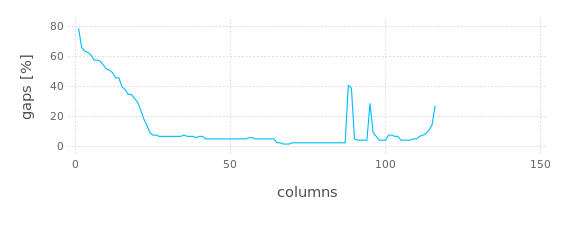

100 31151  100 31151    0     0  13336      0  0:00:02  0:00:02 --:--:-- 13335


In [41]:
msa = read("http://pfam.xfam.org/family/PF09776/alignment/full", Stockholm)

using Gadfly

set_default_plot_size(15cm, 6cm)

plot(   x = 1:ncolumns(msa), # x is a range from 1 to the number of columns
        y = columngapfraction(msa) .* 100.0, # y is a Vector{Float64} with the percentage of gaps of each column
        Geom.line, 
        Guide.ylabel("gaps [%]"),
        Guide.xlabel("columns")  )

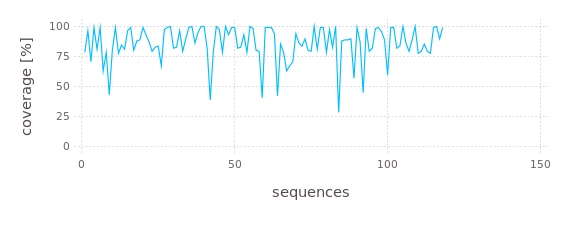

In [42]:
plot(   x = 1:nsequences(msa), # x is a range from 1 to the number of sequences
        y = coverage(msa) .* 100, # y is a Vector{Float64} with the coverage of each sequence
        Geom.line, 
        Guide.ylabel("coverage [%]"),
        Guide.xlabel("sequences") )

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Filter sequences per coverage and columns per gap fraction

Taking advantage of the `filter...!` functions and the `coverage` and `columngapfraction` functions, it’s possible to delete short sequences or columns with a lot of gaps. 


In [43]:
println("\tsequences\tcolumns")

println( "Before:\t", nsequences(msa), "\t\t", ncolumns(msa)  )

filtersequences!(msa, coverage(msa) .>= 0.9) # deletes sequences with less than 90% coverage of the MSA length 

filtercolumns!(msa, columngapfraction(msa) .<= 0.1) # deletes columns with more than 10% of gaps

println( "After:\t", nsequences(msa), "\t\t",  ncolumns(msa)  )

	sequences	columns


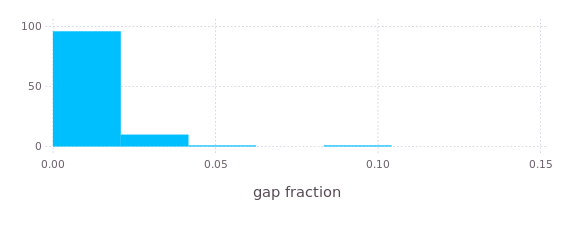

Before:	118		116
After:	48		108


In [44]:
plot(   x = columngapfraction(msa), # Vector{Float64} with the fraction of gaps of each column
        Geom.histogram, 
        Guide.xlabel("gap fraction") )

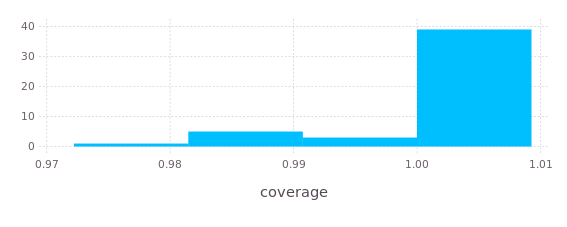

In [45]:
plot(   x = coverage(msa), #  Vector{Float64} with the coverage of each sequence
        Geom.histogram,
        Guide.xlabel("coverage") )

<a href="#"><i class="fa fa-arrow-up"></i></a>

#### Example: Plotting the percentage of identity between sequences

The distribution of the percentage of identity between every pairs of sequences in a MSA, gives an idea of the MSA diversity. In this example, we are going to use `percentidentity` over a MSA to get that values.  

In [46]:
msa = read("http://pfam.xfam.org/family/PF09776/alignment/full", Stockholm)

pid = percentidentity(msa)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31151  100 31151    0     0  23722      0  0:00:01  0:00:01 --:--:-- 23725


118x118 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
 100.0      39.2857   25.8065   33.0435  …   33.6207   38.0952   36.5217
  39.2857  100.0      19.6429   56.5217      54.3103   32.1429   57.3913
  25.8065   19.6429  100.0      22.6087      20.6897   19.6262   20.8696
  33.0435   56.5217   22.6087  100.0         73.2759   33.0435   72.1739
  89.3617   40.1786   26.0417   33.913       34.4828   38.0952   37.3913
  33.0435   56.5217   22.6087   96.5217  …   72.4138   33.0435   71.3043
  57.1429   28.5714   23.3333   21.7391      23.2759   31.4286   23.4783
  95.6044   37.5      24.7312   33.0435      33.6207   38.0952   36.5217
  21.978    15.1786   12.2222   13.913       14.6552   11.4286   15.6522
  44.2105   50.0      25.5319   63.4783      65.5172   30.1887   67.8261
  32.1739   55.6522   22.6087   96.5217  …   72.4138   33.0435   71.3043
  37.6344   32.1429   20.6522   32.1739      31.8966   30.4762   32.1739
  52.0408   33.9286   30.0      28.6957      30.1724   37.14

MIToS stores the matrix of percentage of identity between the aligned sequences as a PairwiseListMatrix
from the [PairwiseListMatrices<span class="fa fa-external-link" aria-hidden="true"></span>](#http://diegozea.github.io/PairwiseListMatrices.jl/) package. This matrix type saves RAM, allowing the storage of  big matrices. In this example, we use the `to_table` function of *PairwiseListMatrices* to convert the matrix into a table with indices for *Gadfly*.

In [47]:
pidtable = PairwiseListMatrices.to_table(pid, false)

6903x3 Array{Any,2}:
   1    2  39.2857
   1    3  25.8065
   1    4  33.0435
   1    5  89.3617
   1    6  33.0435
   1    7  57.1429
   1    8  95.6044
   1    9  21.978 
   1   10  44.2105
   1   11  32.1739
   1   12  37.6344
   1   13  52.0408
   1   14  38.2979
   ⋮              
 113  117  28.5714
 113  118  29.5652
 114  115  26.9565
 114  116  25.8621
 114  117  28.5714
 114  118  24.3478
 115  116  54.3103
 115  117  33.913 
 115  118  62.6087
 116  117  34.4828
 116  118  70.6897
 117  118  33.0435

The function `quantile` gives a quick idea of the percentage identity distribution of the MSA.  

In [60]:
quantile(convert(Vector{Float64}, pidtable[:,3]), [0.00, 0.25, 0.50, 0.75, 1.00])

5-element Array{Float64,1}:
   0.0   
  27.8261
  33.0357
  42.7083
 100.0   

The function `meanpercentidentity` gives the mean value of the percent identity distribution for MSA with less than 300 sequences, or a quick estimate (mean PID in a random sample of sequence pairs) otherwise.  

In [49]:
meanpercentidentity(msa)

37.175095094819326

One can easily plot that matrix and its distribution using `Gadfly`

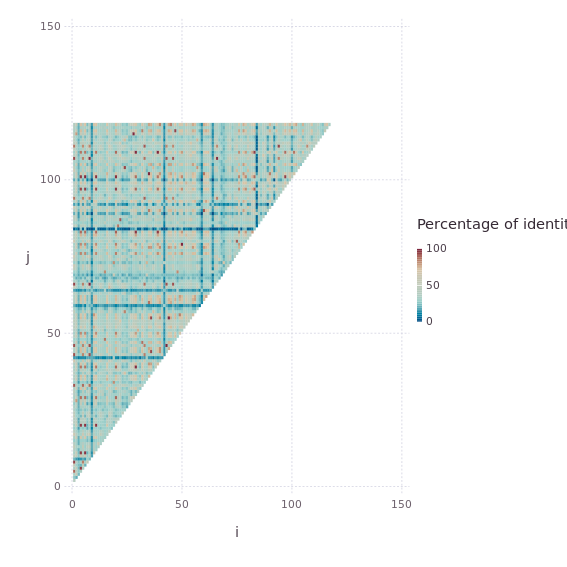

In [50]:
set_default_plot_size(15cm, 15cm)

plot(x     = pidtable[:,1], # i
     y     = pidtable[:,2], # j
     color = pidtable[:,3], # Percentage of identity
     Geom.rectbin,
     Guide.xlabel("i"), Guide.ylabel("j"), Guide.colorkey("Percentage of identity"))

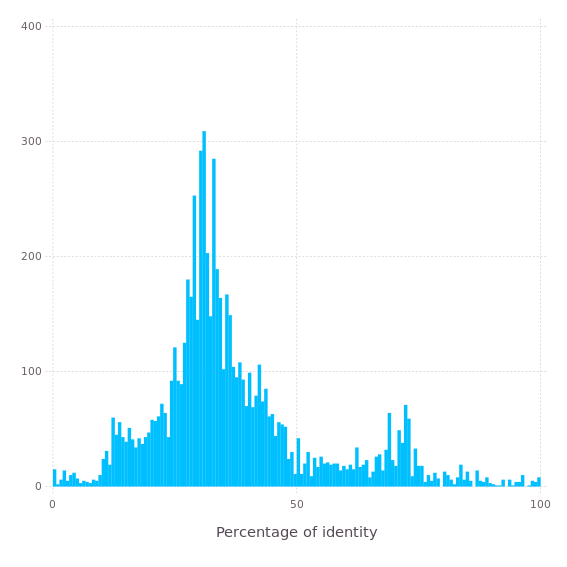

In [51]:
plot(x = pidtable[:,3], Geom.histogram, Guide.xlabel("Percentage of identity"))

<a href="#"><i class="fa fa-arrow-up"></i></a>

## Sequence clustering  

The `MSA` module allow to clusterize the sequences in a MSA. Its `hobohmI`function takes a MSA and a threshold value, and returns a `SequenceCluster` type with the result of a [Hobohm I<span class="fa fa-external-link" aria-hidden="true"></span>](#http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2142204/) sequence clustering. The threshold value should be a fraction of identities (percentage of identity over 100). The Hobohm I algorithm will add a sequence to an existing cluster, if the fraction of identities is equal or greater than the threshold.  
The `SequenceCluster` is sub-type of `ClusteringResult` from the [Clustering.jl<span class="fa fa-external-link" aria-hidden="true"></span>](#http://clusteringjl.readthedocs.org/en/latest/index.html) package. It defines the functions `nclusters` to get the resulting number of clusters, `counts` to get the number of sequences on each cluster and `assignments` to get the cluster number of each sequence. But the more important method is `getweight`, which return the weight of each sequence, since it is used on the `Information` module of MIToS to reduce redundancy.  

In [52]:
msa = read("http://pfam.xfam.org/family/PF07388/alignment/full", Stockholm)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4168  100  4168    0     0   7756      0 --:--:-- --:--:-- --:--:--  7761


4x458 MIToS.MSA.AnnotatedMultipleSequenceAlignment:
 -  -  -  -  -  -  -  -  -  -  -  -  -  …  -  -  -  -  -  -  -  -  -  -  -  -
 M  L  K  K  I  K  K  A  L  F  Q  P  K     -  -  -  -  -  -  -  -  -  -  -  -
 -  -  K  K  L  S  G  L  M  Q  D  I  K     D  F  Q  K  Y  R  I  K  Y  L  Q  L
 -  -  -  -  -  -  -  -  -  -  -  -  -     -  -  -  -  -  -  -  -  -  -  -  -

In [61]:
pid = percentidentity(msa)

4x4 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
 100.0        2.01149    5.97345    0.0    
   2.01149  100.0       16.6667    16.6667 
   5.97345   16.6667   100.0        6.88889
   0.0       16.6667     6.88889  100.0    

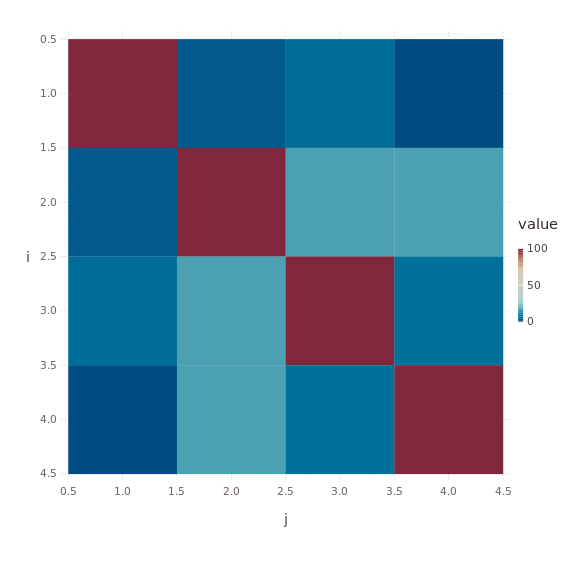

In [64]:
spy(pid)

In [63]:
hobohmI(msa, 0.10)

MIToS.MSA.SequenceClusters([1,3],[1,2,2,2],[1.0,0.3333333333333333,0.3333333333333333,0.3333333333333333])

In [80]:
using Clustering

msa = read("http://pfam.xfam.org/family/PF09776/alignment/full", Stockholm)

pid = percentidentity(msa)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31151  100 31151    0     0  38473      0 --:--:-- --:--:-- --:--:-- 38458


118x118 PairwiseListMatrices.PairwiseListMatrix{Float64,false}:
 100.0      39.2857   25.8065   33.0435  …   33.6207   38.0952   36.5217
  39.2857  100.0      19.6429   56.5217      54.3103   32.1429   57.3913
  25.8065   19.6429  100.0      22.6087      20.6897   19.6262   20.8696
  33.0435   56.5217   22.6087  100.0         73.2759   33.0435   72.1739
  89.3617   40.1786   26.0417   33.913       34.4828   38.0952   37.3913
  33.0435   56.5217   22.6087   96.5217  …   72.4138   33.0435   71.3043
  57.1429   28.5714   23.3333   21.7391      23.2759   31.4286   23.4783
  95.6044   37.5      24.7312   33.0435      33.6207   38.0952   36.5217
  21.978    15.1786   12.2222   13.913       14.6552   11.4286   15.6522
  44.2105   50.0      25.5319   63.4783      65.5172   30.1887   67.8261
  32.1739   55.6522   22.6087   96.5217  …   72.4138   33.0435   71.3043
  37.6344   32.1429   20.6522   32.1739      31.8966   30.4762   32.1739
  52.0408   33.9286   30.0      28.6957      30.1724   37.14

In [92]:
ap = affinityprop(full(pid))

Clustering.AffinityPropResult([1,2,3,4,5,7,9,10,11,12  …  107,108,110,111,112,113,114,116,117,118],[1,2,3,4,5,9,6,93,7,8  …  26,95,96,97,98,99,2,100,101,102],[3,3,1,1,1,1,1,1,3,1  …  3,1,1,1,1,1,1,1,1,1],28,true)

In [93]:
getweight(ap)

118-element Array{Float64,1}:
 0.333333
 0.333333
 1.0     
 1.0     
 1.0     
 0.333333
 1.0     
 0.333333
 1.0     
 1.0     
 0.333333
 1.0     
 1.0     
 ⋮       
 0.333333
 1.0     
 0.333333
 1.0     
 1.0     
 1.0     
 1.0     
 1.0     
 0.333333
 1.0     
 1.0     
 1.0     